In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations

Pre-process full dataset to remove rows with less than 3 reviews and those with missing geographic information

In [2]:
df_restaurant = pd.read_csv("data/full_restaurant_rating_data.csv")
df_is_in_mall = pd.read_csv("data/restaurant_is_in_mall.csv")
df_walking_duration_from_station_exit = pd.read_csv("data/restaurant_walking_distance_from_station_exit.csv")
df_restaurant_nearest_exit = pd.read_csv('data/restaurant_nearest_station_exit.csv')
df_reviews = pd.read_csv('data/full_restaurant_review_data.csv', parse_dates=['date'])

In [3]:
# Merge all the Scraped Datasets into Restaurant Dataset
df_restaurant = df_restaurant.merge(df_is_in_mall[['url', 'is_in_mall', 'mall']], on='url', how='left')
df_restaurant = df_restaurant.merge(df_walking_duration_from_station_exit, on='url', how='left')
df_rating = df_restaurant.merge(df_restaurant_nearest_exit[['station_name', 'station_line_color', 'url', 'distance']], on='url', how='left')

In [4]:
# dropping rows with reviews <= 2: dropping 3935 rows of data
df_rating = df_rating[df_rating['num_of_reviews'] >= 3]
df_rating.shape

(7226, 42)

In [5]:
df_rating = df_rating.dropna(subset=['walking_distance'])
df_rating.shape

(7192, 42)

In [6]:
df_rating.columns

Index(['name', 'address', 'region', 'latitude', 'longitude',
       'nearby_attraction', 'distance_from_attraction', 'price_category',
       'price_range', 'mon_operating_hours', 'tue_operating_hours',
       'wed_operating_hours', 'thu_operating_hours', 'fri_operating_hours',
       'sat_operating_hours', 'sun_operating_hours', 'is_travellors_choice',
       'is_michellin', 'about', 'list_of_meals', 'list_of_cuisines',
       'list_of_features', 'list_of_special_diets', 'num_of_reviews',
       'num_of_rating_1', 'num_of_rating_2', 'num_of_rating_3',
       'num_of_rating_4', 'num_of_rating_5', 'food_rating', 'service_rating',
       'value_rating', 'atmosphere_rating', 'overall_rating', 'url',
       'is_in_mall', 'mall', 'walking_distance', 'walking_duration',
       'station_name', 'station_line_color', 'distance'],
      dtype='object')

### 1. Exploratory Data Analysis - Nearby Attraction

Looking at the various nearby attraction that exist in the dataset

#### 1.1 Proportion of Nearby Attraction

In [7]:
nearby_attraction_count = df_rating['nearby_attraction'].value_counts(dropna=False)
nearby_attraction_fig = px.pie(nearby_attraction_count, names=nearby_attraction_count.index, values='nearby_attraction', width=800, height=400)
nearby_attraction_fig.show()

#### 1.2 Proportion of Nearby Attraction [Excluding Null]

In [8]:
nearby_attraction_count = df_rating['nearby_attraction'].value_counts()
nearby_attraction_fig = px.pie(nearby_attraction_count, names=nearby_attraction_count.index, values='nearby_attraction', width=800, height=400)
nearby_attraction_fig.show()

#### 1.3 Mean Overall Rating across Nearby Attractions

In [9]:
sub_df = df_rating[['nearby_attraction', 'overall_rating']].copy()

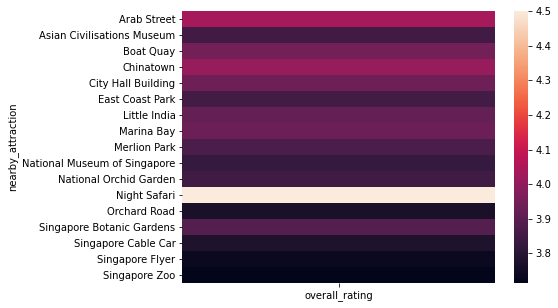

In [10]:
fig, ax = plt.subplots(figsize=(7,5))
df_heatmap = sub_df.pivot_table(values='overall_rating',columns='nearby_attraction', aggfunc=np.mean)
ax = sns.heatmap(df_heatmap.transpose())

#### 1.4 Median Overall Rating across Nearby Attractions

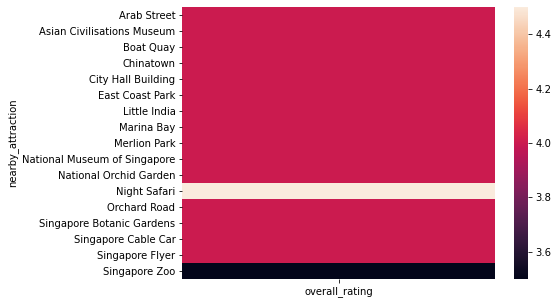

In [11]:
fig, ax = plt.subplots(figsize=(7,5))
df_heatmap = sub_df.pivot_table(values='overall_rating',columns='nearby_attraction',aggfunc=np.median)
ax = sns.heatmap(df_heatmap.transpose())

#### 1.5 Percentage of restaurants with particular rating out of restaurants with that nearby attraction
- row-wise

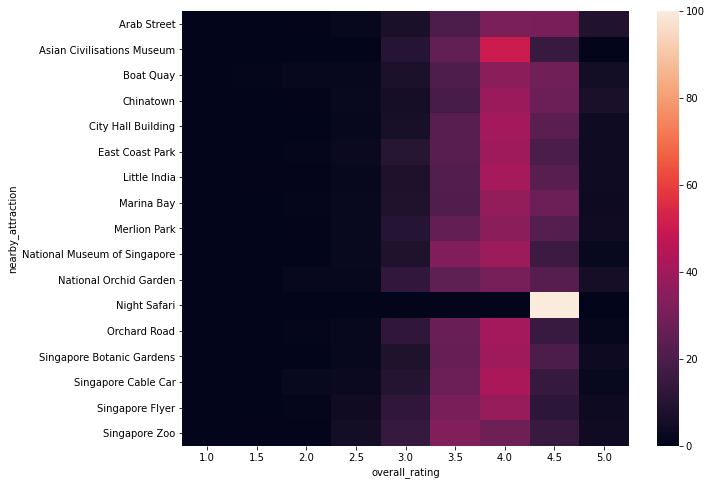

In [12]:
fig, ax = plt.subplots(figsize=(10,8))
rating_nearby_count = df_rating.groupby(['overall_rating', 'nearby_attraction'])['url'].count()
nearby_count = df_rating.groupby(['nearby_attraction'])['url'].count()
df_heatmap = (rating_nearby_count.div(nearby_count, level='nearby_attraction') * 100).unstack(fill_value=0)
ax = sns.heatmap(df_heatmap.transpose())

#### 1.6 Percentage of restaurants with particular nearby attraction out of restaurants with that rating
- column-wise

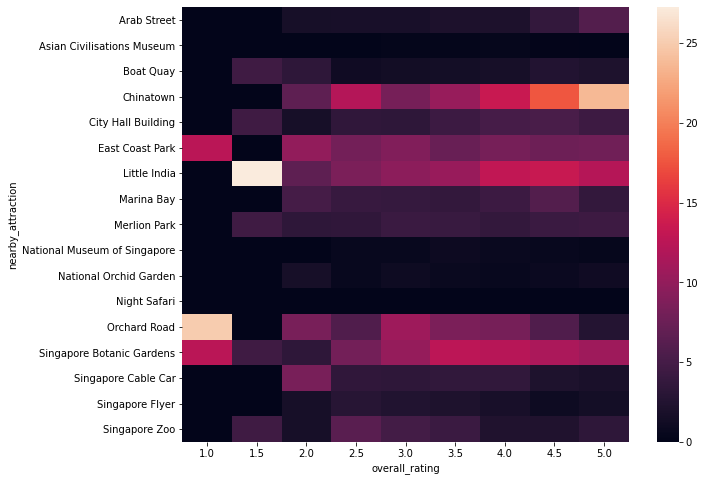

In [13]:
fig, ax = plt.subplots(figsize=(10,8))
rating_nearby_count = df_rating.groupby(['overall_rating', 'nearby_attraction'])['url'].count()
nearby_count = df_rating.groupby(['overall_rating'])['url'].count()
df_heatmap = (rating_nearby_count.div(nearby_count, level='overall_rating') * 100).unstack(fill_value=0)
ax = sns.heatmap(df_heatmap.transpose())

#### 1.7 Number of restaurants by nearby attraction and by rating

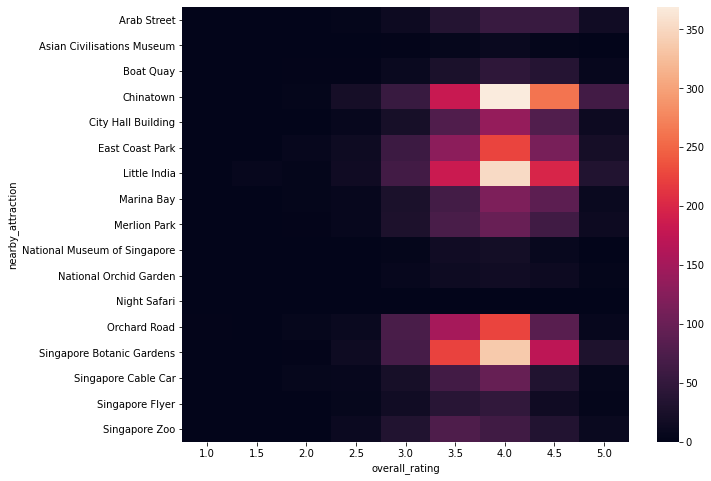

In [14]:
fig, ax = plt.subplots(figsize=(10,8))
df_heatmap = df_rating.groupby(['overall_rating', 'nearby_attraction'])['url'].count().unstack(fill_value=0)
ax = sns.heatmap(df_heatmap.transpose())

### 2. Exploratory Data Analysis - Nearby Attraction [Grouped]

Looking at the various nearby attraction that exist in the dataset after grouping

#### 2.1 Count of restaurants by nearby attraction 

In [15]:
df_rating.groupby(['nearby_attraction'])['url'].count()

nearby_attraction
Arab Street                     179
Asian Civilisations Museum       20
Boat Quay                       128
Chinatown                       957
City Hall Building              335
East Coast Park                 570
Little India                    857
Marina Bay                      318
Merlion Park                    282
National Museum of Singapore     49
National Orchid Garden           53
Night Safari                      1
Orchard Road                    558
Singapore Botanic Gardens       847
Singapore Cable Car             232
Singapore Flyer                 128
Singapore Zoo                   226
Name: url, dtype: int64

Grouping
- 'Asian Civilisations Museum', 'National Museum of Singapore', 'City Hall Building' to 'Museum'
- 'National Orchid Garden', 'Singapore Botanic Gardens' to 'Garden'
- 'Singapore Cable Car', 'Singapore Flyer' to 'Observation'
- 'Night Safari', 'Singapore Zoo' to 'Wildlife'

In [16]:
bucket_df = df_rating.copy()
bucket_df["grouped_nearby_attraction"] = bucket_df['nearby_attraction'].replace(to_replace =['Asian Civilisations Museum', 'National Museum of Singapore', 'City Hall Building'], value ="Museum")
bucket_df["grouped_nearby_attraction"] = bucket_df['grouped_nearby_attraction'].replace(to_replace =['National Orchid Garden', 'Singapore Botanic Gardens'], value ="Garden")
bucket_df["grouped_nearby_attraction"] = bucket_df['grouped_nearby_attraction'].replace(to_replace =['Singapore Cable Car', 'Singapore Flyer'], value ="Observation")
bucket_df["grouped_nearby_attraction"] = bucket_df['grouped_nearby_attraction'].replace(to_replace =['Night Safari', 'Singapore Zoo'], value ="Wildlife")

#### 2.2 Count of restaurants by nearby attraction after grouping

In [17]:
bucket_df.groupby(['grouped_nearby_attraction'])['url'].count()

grouped_nearby_attraction
Arab Street        179
Boat Quay          128
Chinatown          957
East Coast Park    570
Garden             900
Little India       857
Marina Bay         318
Merlion Park       282
Museum             404
Observation        360
Orchard Road       558
Wildlife           227
Name: url, dtype: int64

#### 2.3 Proportion of Grouped Nearby Attraction 

In [18]:
nearby_attraction_count = bucket_df['grouped_nearby_attraction'].value_counts(dropna=False)
nearby_attraction_fig = px.pie(nearby_attraction_count, names=nearby_attraction_count.index, values='grouped_nearby_attraction', width=800, height=400)
nearby_attraction_fig.show()

#### 2.4 Proportion of Grouped Nearby Attraction [Excluding Null]

In [19]:
nearby_attraction_count = bucket_df['grouped_nearby_attraction'].value_counts()
nearby_attraction_fig = px.pie(nearby_attraction_count, names=nearby_attraction_count.index, values='grouped_nearby_attraction', width=800, height=400)
nearby_attraction_fig.show()

#### 2.5 Mean Overall Rating across Grouped Nearby Attractions

In [20]:
sub_df = bucket_df[['grouped_nearby_attraction', 'overall_rating']].copy()

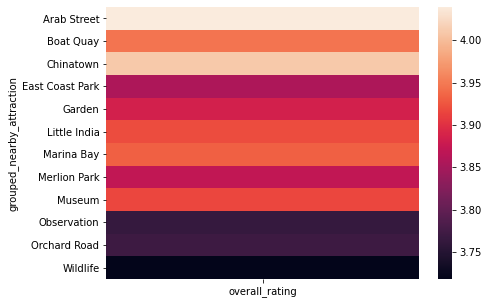

In [21]:
fig, ax = plt.subplots(figsize=(7,5))
df_heatmap = sub_df.pivot_table(values='overall_rating',columns='grouped_nearby_attraction', aggfunc=np.mean)
ax = sns.heatmap(df_heatmap.transpose())

#### 2.6 Median Overall Rating across Grouped Nearby Attractions

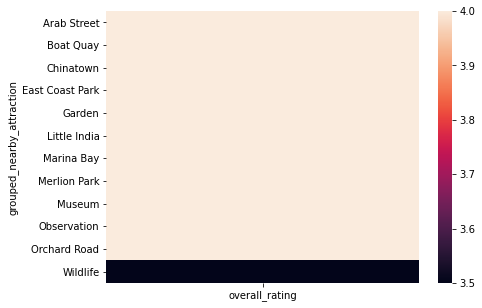

In [22]:
fig, ax = plt.subplots(figsize=(7,5))
df_heatmap = sub_df.pivot_table(values='overall_rating',columns='grouped_nearby_attraction',aggfunc=np.median)
ax = sns.heatmap(df_heatmap.transpose())

#### 2.7 Percentage of restaurants with particular rating out of restaurants with that grouped nearby attraction
- row-wise

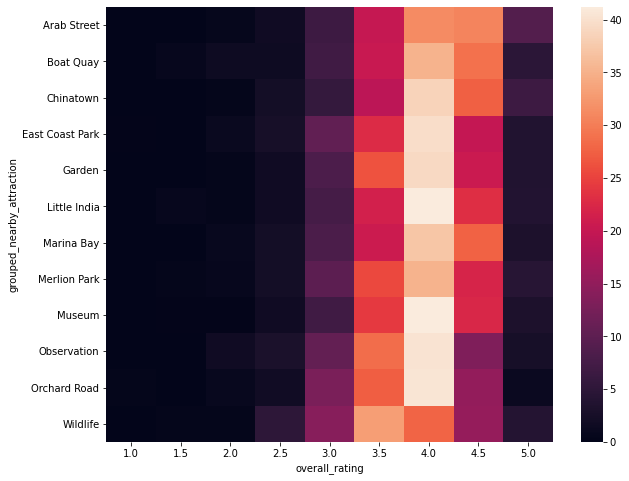

In [23]:
fig, ax = plt.subplots(figsize=(10,8))
rating_nearby_count = bucket_df.groupby(['overall_rating', 'grouped_nearby_attraction'])['url'].count()
nearby_count = bucket_df.groupby(['grouped_nearby_attraction'])['url'].count()
df_heatmap = (rating_nearby_count.div(nearby_count, level='grouped_nearby_attraction') * 100).unstack(fill_value=0)
ax = sns.heatmap(df_heatmap.transpose())

#### 2.8 Percentage of restaurants with particular grouped nearby attraction out of restaurants with that rating
- column-wise

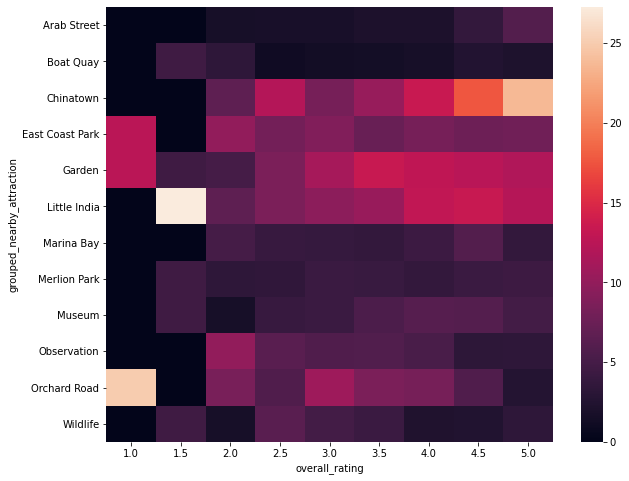

In [24]:
fig, ax = plt.subplots(figsize=(10,8))
rating_nearby_count = bucket_df.groupby(['overall_rating', 'grouped_nearby_attraction'])['url'].count()
nearby_count = bucket_df.groupby(['overall_rating'])['url'].count()
df_heatmap = (rating_nearby_count.div(nearby_count, level='overall_rating') * 100).unstack(fill_value=0)
ax = sns.heatmap(df_heatmap.transpose())

#### 2.8 Number of restaurants by grouped nearby attraction and by rating

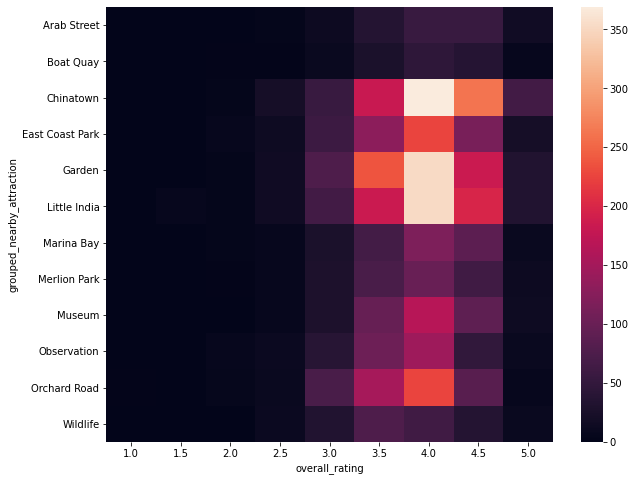

In [25]:
fig, ax = plt.subplots(figsize=(10,8))
df_heatmap = bucket_df.groupby(['overall_rating', 'grouped_nearby_attraction'])['url'].count().unstack(fill_value=0)
ax = sns.heatmap(df_heatmap.transpose())

### 3. EDA <-> Feature Engineering
#### 3.0 Check feasibility of feature cross: Grouped Nearby Attraction, Distance From Attraction

In [26]:
# group nearby attractions together, same as what is done in cell above except change in column name
bucket_df = df_rating.copy()
bucket_df["nearby_attraction"] = bucket_df['nearby_attraction'].replace(to_replace =['Asian Civilisations Museum', 'National Museum of Singapore', 'City Hall Building'], value ="Museum")
bucket_df["nearby_attraction"] = bucket_df['nearby_attraction'].replace(to_replace =['National Orchid Garden', 'Singapore Botanic Gardens'], value ="Garden")
bucket_df["nearby_attraction"] = bucket_df['nearby_attraction'].replace(to_replace =['Singapore Cable Car', 'Singapore Flyer'], value ="Observation")
bucket_df["nearby_attraction"] = bucket_df['nearby_attraction'].replace(to_replace =['Night Safari', 'Singapore Zoo'], value ="Wildlife")

In [27]:
bucket_df['nearby_attraction'] = bucket_df['nearby_attraction'].str.replace(" ", "_")
bucket_df['nearby_attraction'] = bucket_df['nearby_attraction'].str.lower()

In [28]:
# too little samples in each grouped_nearby_attraction X distance_from_attraction pairing
bucket_df.groupby(['nearby_attraction', 'distance_from_attraction']).agg({'url': 'count'})

url
nearby_attraction distance_from_attraction     
arab_street       0.0                        14
                  0.1                        22
                  0.2                        19
                  0.3                        22
                  0.4                         9
...                                         ...
wildlife          6.5                         1
                  6.7                         1
                  6.8                         1
                  7.0                         4
                  7.8                         3

[322 rows x 1 columns]

In [29]:
# look at min, max, median 
bucket_df.groupby(['nearby_attraction'], dropna=False).agg({'distance_from_attraction': ['min', 'max', 'median']})

distance_from_attraction            
                                       min  max median
nearby_attraction                                     
arab_street                            0.0  2.8    0.5
boat_quay                              0.2  0.7    0.4
chinatown                              0.0  1.9    0.5
east_coast_park                        0.3  6.3    2.1
garden                                 0.0  5.8    1.9
little_india                           0.0  3.1    0.8
marina_bay                             0.1  2.0    0.6
merlion_park                           0.0  1.1    0.6
museum                                 0.0  0.9    0.4
observation                            0.0  4.2    0.9
orchard_road                           0.0  2.3    0.4
wildlife                               0.0  7.8    5.4
NaN                                    NaN  NaN    NaN

In [30]:
# count by nearby attraction
bucket_df.groupby(['nearby_attraction'], dropna=False)['url'].count()

nearby_attraction
arab_street         179
boat_quay           128
chinatown           957
east_coast_park     570
garden              900
little_india        857
marina_bay          318
merlion_park        282
museum              404
observation         360
orchard_road        558
wildlife            227
NaN                1452
Name: url, dtype: int64

#### 3.1 Feature cross: Grouped Nearby Attraction, Above Median Distance From Attraction

In [31]:
median_by_attraction = bucket_df.groupby(['nearby_attraction']).agg({'distance_from_attraction': ['min', 'max', 'median']})['distance_from_attraction']['median'].to_dict()
bucket_df["above_median"] =  bucket_df[['distance_from_attraction', 'nearby_attraction']].apply(lambda x: x['distance_from_attraction'] > median_by_attraction[x['nearby_attraction']] if not pd.isna(x['nearby_attraction']) else np.nan, axis=1)
bucket_df["above_median"] = bucket_df["above_median"].astype(float)

In [32]:
bucket_df["above_median"].unique()

array([ 1.,  0., nan])

In [33]:
# count by nearby attraction and above median distance
bucket_df.groupby(['nearby_attraction', 'above_median']).agg({'url': 'count'})

url
nearby_attraction above_median     
arab_street       0.0           139
                  1.0            40
boat_quay         0.0            76
                  1.0            52
chinatown         0.0           591
                  1.0           366
east_coast_park   0.0           299
                  1.0           271
garden            0.0           463
                  1.0           437
little_india      0.0           454
                  1.0           403
marina_bay        0.0           226
                  1.0            92
merlion_park      0.0           192
                  1.0            90
museum            0.0           211
                  1.0           193
observation       0.0           201
                  1.0           159
orchard_road      0.0           323
                  1.0           235
wildlife          0.0           125
                  1.0           102

In [34]:
from sklearn.preprocessing import OneHotEncoder # categorical variable so do one hot encoding
nearby_attraction_enc = OneHotEncoder(categories='auto')
# One hot encoding for categorical variable
features_nearby_attraction_train = nearby_attraction_enc.fit_transform(bucket_df[['nearby_attraction']])

# TODO transform on test

In [35]:
nearby_attraction_ohe_columns = nearby_attraction_enc.get_feature_names_out(['nearby_attraction'])
nearby_attraction_ohe_df = pd.DataFrame(features_nearby_attraction_train.toarray(), columns=nearby_attraction_ohe_columns)
bucket_ohe_df = pd.concat([bucket_df.drop(columns=['nearby_attraction']).reset_index(drop=True), nearby_attraction_ohe_df.reset_index(drop=True)], axis=1)

In [36]:
nearby_attraction_ohe_columns

array(['nearby_attraction_arab_street', 'nearby_attraction_boat_quay',
       'nearby_attraction_chinatown', 'nearby_attraction_east_coast_park',
       'nearby_attraction_garden', 'nearby_attraction_little_india',
       'nearby_attraction_marina_bay', 'nearby_attraction_merlion_park',
       'nearby_attraction_museum', 'nearby_attraction_observation',
       'nearby_attraction_orchard_road', 'nearby_attraction_wildlife',
       'nearby_attraction_nan'], dtype=object)

In [37]:
cross_cols = []
bucket_ohe_df["above_median"] = bucket_ohe_df["above_median"].replace(np.nan, 0)
for col in nearby_attraction_ohe_columns:
    if col == 'nearby_attraction_nan':
        continue
    cross = col + "_above_median"
    bucket_ohe_df[cross] = bucket_ohe_df[col] * bucket_ohe_df["above_median"]
    cross_cols.append(cross)

In [38]:
attraction_eda_cols = []
attraction_eda_cols.extend(cross_cols)
attraction_eda_cols.extend(nearby_attraction_ohe_columns)

#### 3.2 EDA: Using feature cross columns only in Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [40]:
cross_cols

['nearby_attraction_arab_street_above_median',
 'nearby_attraction_boat_quay_above_median',
 'nearby_attraction_chinatown_above_median',
 'nearby_attraction_east_coast_park_above_median',
 'nearby_attraction_garden_above_median',
 'nearby_attraction_little_india_above_median',
 'nearby_attraction_marina_bay_above_median',
 'nearby_attraction_merlion_park_above_median',
 'nearby_attraction_museum_above_median',
 'nearby_attraction_observation_above_median',
 'nearby_attraction_orchard_road_above_median',
 'nearby_attraction_wildlife_above_median']

In [41]:
len(bucket_ohe_df)

7192

In [42]:
bucket_ohe_df['overall_rating'].unique()

array([4. , 5. , 4.5, 3.5, 3. , 2.5, 2. , 1.5, 1. ])

In [43]:
X = bucket_ohe_df[cross_cols]
y = bucket_ohe_df['overall_rating'].astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

logreg = LogisticRegression(multi_class='multinomial')

# fit the model with data
logreg.fit(X_train, y_train)

# predict the response for new observations
y_pred_train = logreg.predict(X_train)

# calculate accuracy
print("training accuracy: {}".format(metrics.accuracy_score(y_train, logreg.predict(X_train))))
print("test accuracy: {}".format(metrics.accuracy_score(y_test, logreg.predict(X_test))))

# calculate AUC
print("training AUC: {}".format(metrics.roc_auc_score(y_train, logreg.predict_proba(X_train), multi_class="ovr")))
print("test AUC: {}".format(metrics.roc_auc_score(y_test, logreg.predict_proba(X_test), multi_class="ovr")))

training accuracy: 0.38023730070448647
test accuracy: 0.38654060066740825
training AUC: 0.5815510706821079
test AUC: 0.5181323622195464


In [44]:
df = pd.DataFrame(zip(X_train.columns, np.transpose(logreg.coef_)), columns=['features', 'coef']) 
df = pd.concat([df, df.coef.apply(pd.Series).add_prefix('coef_')], axis = 1)
df

,features,coef,coef_0,coef_1,coef_2,coef_3,coef_4,coef_5,coef_6,coef_7,coef_8
0,nearby_attraction_arab_street_above_median,"[-0.01468187364112731, -0.06892292819726215, -...",-0.014682,-0.068923,-0.178599,0.657115,-0.477373,-0.363766,-0.273661,0.752178,-0.032289
1,nearby_attraction_boat_quay_above_median,"[-0.022928308150050453, -0.10527672679463988, ...",-0.022928,-0.105277,0.463848,-0.049576,-0.440267,0.171370,0.162403,-0.290035,0.110462
2,nearby_attraction_chinatown_above_median,"[-0.11476839665863574, -0.4262473777441061, 0....",-0.114768,-0.426247,0.046018,0.129699,-0.188366,-0.048163,0.347567,0.383723,-0.129462
3,nearby_attraction_east_coast_park_above_median,"[-0.08753248609225742, -0.3423386079114413, -0...",-0.087532,-0.342339,-0.165820,-0.302354,0.202297,0.105474,0.272146,0.180000,0.138128
4,nearby_attraction_garden_above_median,"[-0.12843194773308117, -0.46528303395550946, -...",-0.128432,-0.465283,-0.038421,0.138112,0.384771,0.390036,0.152033,0.049287,-0.482102
5,nearby_attraction_little_india_above_median,"[-0.14833809708705015, 0.8795946142474343, -0....",-0.148338,0.879595,-0.153327,-0.014698,-0.108451,0.004738,0.034351,0.013728,-0.507598
6,nearby_attraction_marina_bay_above_median,"[-0.03850217774199579, -0.16993367085741765, 0...",-0.038502,-0.169934,0.757958,-0.339056,-0.388520,-0.183018,-0.113668,0.214048,0.260691
7,nearby_attraction_merlion_park_above_median,"[-0.02856183387839351, -0.12765787852123095, -...",-0.028562,-0.127658,-0.307986,0.254314,0.059503,0.416255,0.320093,0.282456,-0.868415
8,nearby_attraction_museum_above_median,"[-0.07134953394760454, 0.4160213884345144, -0....",-0.071350,0.416021,-0.055261,-0.139192,-0.197265,0.009939,0.184969,0.113819,-0.261681
9,nearby_attraction_observation_above_median,"[-0.06494361294795653, -0.2688614759902957, 0....",-0.064944,-0.268861,0.785861,0.353950,-0.538799,-0.122653,0.065193,-0.208798,-0.000949


In [45]:
logreg.classes_

array(['1.0', '1.5', '2.0', '2.5', '3.0', '3.5', '4.0', '4.5', '5.0'],
      dtype=object)

#### 3.3 EDA: Using feature cross columns only and nearby_attraction_nan indicator in Logistic Regression

In [46]:
bucket_ohe_df['overall_rating'].unique()

array([4. , 5. , 4.5, 3.5, 3. , 2.5, 2. , 1.5, 1. ])

In [47]:
X = bucket_ohe_df[cross_cols + ["nearby_attraction_nan"]]
y = bucket_ohe_df['overall_rating'].astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

logreg = LogisticRegression(multi_class='multinomial', max_iter=200)

# fit the model with data
logreg.fit(X_train, y_train)

# predict the response for new observations
y_pred_train = logreg.predict(X_train)

# calculate accuracy
print("training accuracy: {}".format(metrics.accuracy_score(y_train, logreg.predict(X_train))))
print("test accuracy: {}".format(metrics.accuracy_score(y_test, logreg.predict(X_test))))

# calculate AUC
print("training AUC: {}".format(metrics.roc_auc_score(y_train, logreg.predict_proba(X_train), multi_class="ovr")))
print("test AUC: {}".format(metrics.roc_auc_score(y_test, logreg.predict_proba(X_test), multi_class="ovr")))

training accuracy: 0.38023730070448647
test accuracy: 0.38654060066740825
training AUC: 0.6174702465264323
test AUC: 0.5700528820842904


In [48]:
df = pd.DataFrame(zip(X_train.columns, np.transpose(logreg.coef_)), columns=['features', 'coef']) 
df = pd.concat([df, df.coef.apply(pd.Series).add_prefix('coef_')], axis = 1)
df

,features,coef,coef_0,coef_1,coef_2,coef_3,coef_4,coef_5,coef_6,coef_7,coef_8
0,nearby_attraction_arab_street_above_median,"[-0.01362286645496009, -0.04660498416962134, -...",-0.013623,-0.046605,-0.145386,0.755031,-0.443285,-0.331267,-0.322023,0.647472,-0.100313
1,nearby_attraction_boat_quay_above_median,"[-0.021418987168667688, -0.07224752065381088, ...",-0.021419,-0.072248,0.542648,0.032245,-0.405134,0.201158,0.103193,-0.398814,0.018370
2,nearby_attraction_chinatown_above_median,"[-0.10982615100048472, -0.3196033111507493, 0....",-0.109826,-0.319603,0.180412,0.246944,-0.166768,-0.043831,0.257908,0.234095,-0.279330
3,nearby_attraction_east_coast_park_above_median,"[-0.08312563062182972, -0.25109483046886244, -...",-0.083126,-0.251095,-0.052187,-0.191762,0.232068,0.117856,0.191616,0.040502,-0.003873
4,nearby_attraction_garden_above_median,"[-0.12314510808795581, -0.35184528248921637, 0...",-0.123145,-0.351845,0.096171,0.255209,0.404372,0.391878,0.060337,-0.102268,-0.630710
5,nearby_attraction_little_india_above_median,"[-0.1449607319963747, 1.126735964146195, -0.03...",-0.144961,1.126736,-0.030490,0.084623,-0.108544,-0.013885,-0.077979,-0.158384,-0.677116
6,nearby_attraction_marina_bay_above_median,"[-0.03629758267750437, -0.11935856420146665, 0...",-0.036298,-0.119359,0.881904,-0.254371,-0.354635,-0.162109,-0.182968,0.086886,0.140950
7,nearby_attraction_merlion_park_above_median,"[-0.026820246140545206, -0.0887082297403388, -...",-0.026820,-0.088708,-0.257885,0.353170,0.097290,0.442193,0.255930,0.162103,-0.937273
8,nearby_attraction_museum_above_median,"[-0.0681857743255238, 0.5521226718930221, 0.04...",-0.068186,0.552123,0.049460,-0.036734,-0.176350,0.013732,0.096734,-0.032928,-0.397851
9,nearby_attraction_observation_above_median,"[-0.062024984089053777, -0.19516148820185902, ...",-0.062025,-0.195161,0.928820,0.467341,-0.515746,-0.115775,-0.019949,-0.350292,-0.137213


#### 3.3 EDA: Using feature cross columns and all One-Hot Encoded nearby_attraction columns in Logistic Regression

In [49]:
attraction_eda_cols

['nearby_attraction_arab_street_above_median',
 'nearby_attraction_boat_quay_above_median',
 'nearby_attraction_chinatown_above_median',
 'nearby_attraction_east_coast_park_above_median',
 'nearby_attraction_garden_above_median',
 'nearby_attraction_little_india_above_median',
 'nearby_attraction_marina_bay_above_median',
 'nearby_attraction_merlion_park_above_median',
 'nearby_attraction_museum_above_median',
 'nearby_attraction_observation_above_median',
 'nearby_attraction_orchard_road_above_median',
 'nearby_attraction_wildlife_above_median',
 'nearby_attraction_arab_street',
 'nearby_attraction_boat_quay',
 'nearby_attraction_chinatown',
 'nearby_attraction_east_coast_park',
 'nearby_attraction_garden',
 'nearby_attraction_little_india',
 'nearby_attraction_marina_bay',
 'nearby_attraction_merlion_park',
 'nearby_attraction_museum',
 'nearby_attraction_observation',
 'nearby_attraction_orchard_road',
 'nearby_attraction_wildlife',
 'nearby_attraction_nan']

In [50]:
X = bucket_ohe_df[attraction_eda_cols]
y = bucket_ohe_df['overall_rating'].astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

logreg = LogisticRegression(multi_class='multinomial', max_iter=200)

# fit the model with data
logreg.fit(X_train, y_train)

# predict the response for new observations
y_pred_train = logreg.predict(X_train)

# calculate accuracy
print("training accuracy: {}".format(metrics.accuracy_score(y_train, logreg.predict(X_train))))
print("test accuracy: {}".format(metrics.accuracy_score(y_test, logreg.predict(X_test))))

# calculate AUC
print("training AUC: {}".format(metrics.roc_auc_score(y_train, logreg.predict_proba(X_train), multi_class="ovr")))
print("test AUC: {}".format(metrics.roc_auc_score(y_test, logreg.predict_proba(X_test), multi_class="ovr")))

training accuracy: 0.38116425658138675
test accuracy: 0.3832035595105673
training AUC: 0.6703243918834482
test AUC: 0.5844301693058322


In [51]:
df = pd.DataFrame(zip(X_train.columns, np.transpose(logreg.coef_)), columns=['features', 'coef']) 
df = pd.concat([df, df.coef.apply(pd.Series).add_prefix('coef_')], axis = 1)
df

,features,coef,coef_0,coef_1,coef_2,coef_3,coef_4,coef_5,coef_6,coef_7,coef_8
0,nearby_attraction_arab_street_above_median,"[-0.011550998243496756, -0.04028032397043773, ...",-0.011551,-0.040280,-0.162584,0.842025,-0.341797,-0.222009,-0.032721,0.435978,-0.467061
1,nearby_attraction_boat_quay_above_median,"[-0.021267829030254974, -0.1540722322863616, 0...",-0.021268,-0.154072,0.252647,0.009194,0.109998,0.280601,0.358201,-0.742624,-0.092677
2,nearby_attraction_chinatown_above_median,"[-0.0732468788129228, -0.18907610036145778, 0....",-0.073247,-0.189076,0.438756,0.198587,0.147682,0.159114,0.271071,-0.111572,-0.841316
3,nearby_attraction_east_coast_park_above_median,"[-0.06315168318272855, -0.17658635246578175, -...",-0.063152,-0.176586,-0.440157,-0.281875,0.112096,0.170062,0.113844,0.271906,0.293861
4,nearby_attraction_garden_above_median,"[-0.08520843580723873, -0.22600725197466712, 0...",-0.085208,-0.226007,0.457677,0.482599,0.300051,0.074469,-0.218534,-0.389806,-0.395240
5,nearby_attraction_little_india_above_median,"[-0.10703975721982129, 0.701739403594773, -0.0...",-0.107040,0.701739,-0.027194,0.716064,-0.055021,0.063906,-0.307005,-0.145536,-0.839914
6,nearby_attraction_marina_bay_above_median,"[-0.02854415629767398, -0.09032371889003958, 0...",-0.028544,-0.090324,0.915601,-0.361505,-0.423532,-0.106586,-0.225161,-0.190137,0.510188
7,nearby_attraction_merlion_park_above_median,"[-0.023460242029494427, -0.1414122233931738, -...",-0.023460,-0.141412,-0.344396,0.346947,-0.000113,0.446150,0.551868,0.091342,-0.926926
8,nearby_attraction_museum_above_median,"[-0.05441124167174201, 0.4854753823491286, 0.2...",-0.054411,0.485475,0.222217,-0.006622,-0.138378,-0.133795,-0.022665,0.022360,-0.374181
9,nearby_attraction_observation_above_median,"[-0.04927494861358414, -0.14717657918036844, 0...",-0.049275,-0.147177,0.485622,0.069782,-0.968368,-0.380469,0.100940,0.351154,0.537789
